# DATA 200 Final Project (Peng Gu, Xi Chen, Kewei Sui)

In [1]:
# import all packages
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

In [3]:
# import all datasets
df_player = pd.read_csv('dataset/2012-18_playerBoxScore.csv')
df_allnbatm = pd.read_csv('dataset/all_nba_team_2012_2017.csv')
df_player['gmDate'] = pd.to_datetime(df_player['gmDate'], format='%Y-%m-%d')
df_player['playBDate'] = pd.to_datetime(df_player['playBDate'], format='%Y-%m-%d')

df_allnbatm.head(10)

,name,year,position,team,sub_team
0,LeBron James,2012,F,Miami Heat,1
1,Kevin Durant,2012,F,Oklahoma City Thunder,1
2,Tim Duncan,2012,C,San Antonio Spurs,1
3,Kobe Bryant,2012,G,Los Angeles Lakers,1
4,Chris Paul,2012,G,L.A. Clippers,1
5,Carmelo Anthony,2012,F,New York Knicks,2
6,Blake Griffin,2012,F,L.A. Clippers,2
7,Marc Gasol,2012,C,Memphis Grizzlies,2
8,Tony Parker,2012,G,San Antonio Spurs,2
9,Russell Westbrook,2012,G,Oklahoma City Thunder,2


In [4]:
# We set the number of NBA season based on the game date and the start date of each season in 2012-18
start_dates = ['2012-10-30', '2013-10-29', '2014-10-28', '2015-10-27','2016-10-25','2017-10-17','2018-10-16']
for i in range(len(start_dates)):
    start_dates[i] = datetime.datetime.strptime(start_dates[i],'%Y-%m-%d')

def setSeasons(gm_date):
    for i in range(len(start_dates) - 1):
        if gm_date >= start_dates[i] and gm_date < start_dates[i + 1]:
            return start_dates[i].year

df_player["seasYear"] = df_player['gmDate'].apply(lambda x:setSeasons(x))

In [5]:
# We find out in the dataset "2012-18_playerBoxScore.csv", and there is no data for the pre or post season
# Thus, we will only evaluate players based on their performances in the regular season
df_player = df_player[df_player.seasTyp != 'Pre']
df_player = df_player[df_player.seasTyp != 'Post']

In [6]:
df_player.loc[df_player['playMin'] != 0, 'playFIC40'] = ((df_player['playPTS'] + df_player['playORB'] + 0.75 * df_player['playDRB'] + df_player['playAST'] + df_player['playSTL'] + df_player['playBLK'] - 0.75 * df_player['playFGA'] - 0.375 * df_player['playFTA'] - df_player['playTO'] - 0.5 * df_player['playPF']) * 40) / df_player['playMin']
df_player.loc[df_player['playMin'] == 0, 'playFIC40'] = 0

In [7]:
df_player["gameScore"] = df_player["playPTS"] + 0.4 * df_player["playFGM"] - 0.7 * df_player["playFGA"] - 0.4 * (df_player["playFTA"] - df_player["playFTM"]) + 0.7 * df_player["playORB"] + 0.3 * df_player["playDRB"] + df_player["playSTL"] + 0.7 * df_player["playAST"] + 0.7 * df_player["playBLK"] - 0.4 * df_player["playPF"] - df_player["playTO"]

In [8]:
df_player = df_player.replace([np.inf, -np.inf], np.nan)
df_player.isna().sum()

gmDate         0
gmTime         0
seasTyp        0
playLNm        0
playFNm        0
teamAbbr       0
teamConf       0
teamDiv        0
teamLoc        0
teamRslt       0
teamDayOff     0
offLNm1        0
offFNm1        0
offLNm2        0
offFNm2        0
offLNm3       41
offFNm3       41
playDispNm     0
playStat       0
playMin        0
playPos        0
playHeight     0
playWeight     0
playBDate      0
playPTS        0
playAST        0
playTO         0
playSTL        0
playBLK        0
playPF         0
playFGA        0
playFGM        0
playFG%        0
play2PA        0
play2PM        0
play2P%        0
play3PA        0
play3PM        0
play3P%        0
playFTA        0
playFTM        0
playFT%        0
playORB        0
playDRB        0
playTRB        0
opptAbbr       0
opptConf       0
opptDiv        0
opptLoc        0
opptRslt       0
opptDayOff     0
seasYear       0
playFIC40      0
gameScore      0
dtype: int64

In [9]:
# Data cleaning
df_player['offLNm3'] = df_player['offLNm3'].fillna(df_player['offLNm2'])
df_player['offFNm3'] = df_player['offFNm3'].fillna(df_player['offFNm2'])
# df_player.loc[df_player['playDispNm'] == 'Goran Dragić']['playDispNm'] = 'Goran Dragic'
df_player['playDispNm'] = df_player['playDispNm'].replace({'Goran Dragić':'Goran Dragic'})
df_player.isna().sum()

gmDate        0
gmTime        0
seasTyp       0
playLNm       0
playFNm       0
teamAbbr      0
teamConf      0
teamDiv       0
teamLoc       0
teamRslt      0
teamDayOff    0
offLNm1       0
offFNm1       0
offLNm2       0
offFNm2       0
offLNm3       0
offFNm3       0
playDispNm    0
playStat      0
playMin       0
playPos       0
playHeight    0
playWeight    0
playBDate     0
playPTS       0
playAST       0
playTO        0
playSTL       0
playBLK       0
playPF        0
playFGA       0
playFGM       0
playFG%       0
play2PA       0
play2PM       0
play2P%       0
play3PA       0
play3PM       0
play3P%       0
playFTA       0
playFTM       0
playFT%       0
playORB       0
playDRB       0
playTRB       0
opptAbbr      0
opptConf      0
opptDiv       0
opptLoc       0
opptRslt      0
opptDayOff    0
seasYear      0
playFIC40     0
gameScore     0
dtype: int64

In [10]:
# Data cleaning
df_player = df_player.drop(columns=['teamDiv', 'teamDayOff', 'offLNm1', 'offFNm1', 'offLNm2', 'offFNm2', \
      'offLNm3', 'offFNm3', 'opptDiv', 'opptDayOff'])

In [11]:
df_player["playPos"] = df_player["playPos"].replace({'PG':'G', 'SG':'G', 'SF':'F', 'PF':'F'})

In [12]:
player_starter_bench = pd.pivot_table(data=df_player, index=['playDispNm','seasYear'],columns='playStat',values='teamAbbr',aggfunc='count')
player_starter_bench = player_starter_bench.fillna(0).reset_index()

In [13]:
# EDA
allnba_starter_bench = player_starter_bench.merge(right=df_allnbatm, how='inner', left_on=['playDispNm', 'seasYear'], right_on=['name','year'])
allnba_starter_bench.drop(columns=['name', 'year'], inplace=True)
allnba_starter_bench.sort_values(by=['seasYear', 'sub_team'], inplace=True, ascending=True)

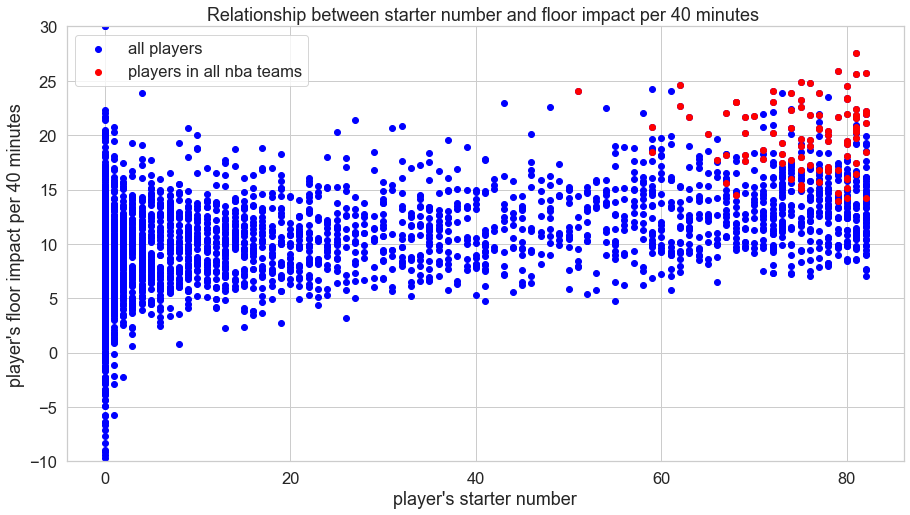

In [14]:

df_player_starter_vs_FIC40 = df_player[['playDispNm', 'playFIC40', 'seasYear']].groupby(["playDispNm", "seasYear"]).mean()
df_player_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(player_starter_bench, on=['playDispNm', 'seasYear'], how='inner')

#df_2012 = df[df["seasYear"] == 2012]
#allnba_2012 = allnba_regular_starter_bench[allnba_regular_starter_bench["seasYear"] == 2012]

plt.figure(figsize=(15,8))
plt.ylim(-10, 30)
plt.title("Relationship between starter number and floor impact per 40 minutes ")
plt.xlabel("player's starter number")
plt.ylabel("player's floor impact per 40 minutes")

df_allnba_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(allnba_starter_bench, on=["playDispNm", "seasYear", "Bench", "Starter"])

plt.scatter(df_player_starter_vs_FIC40['Starter'], df_player_starter_vs_FIC40["playFIC40"], color='blue', label="all players")
plt.scatter(df_allnba_starter_vs_FIC40['Starter'], df_allnba_starter_vs_FIC40['playFIC40'], color='red', label="players in all nba teams")
plt.legend();

In [15]:
# Cell for Pre-Processing data to fit the model
# display(df_player)
# df_model = df_player[['playDispNm', 'teamLoc','teamRslt', 'teamAbbr', 'teamConf','playStat','playMin','playPos','playHeight','playWeight','playBDate',]]
# join 
df_allnbatm['is_allnba'] = 1
df_player = df_player.merge(right=df_allnbatm, how='left', left_on=['playDispNm','seasYear'], right_on=['name','year'])
df_player = df_player.drop(columns=['name','year','position','team'])
df_player['sub_team'].fillna(0, inplace=True)
df_player['is_allnba'].fillna(0,inplace=True)
df_player

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamLoc,teamRslt,playDispNm,...,playTRB,opptAbbr,opptConf,opptLoc,opptRslt,seasYear,playFIC40,gameScore,sub_team,is_allnba
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Away,Loss,A.J. Price,...,2,CLE,East,Home,Win,2012,4.310345,2.5,0.0,0.0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Away,Loss,Trevor Ariza,...,3,CLE,East,Home,Win,2012,22.000000,12.7,0.0,0.0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Away,Loss,Emeka Okafor,...,7,CLE,East,Home,Win,2012,16.000000,9.3,0.0,0.0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Away,Loss,Bradley Beal,...,3,CLE,East,Home,Win,2012,9.090909,4.8,0.0,0.0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Away,Loss,Trevor Booker,...,1,CLE,East,Home,Win,2012,-11.176471,-4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155708,2018-04-11,10:30,Regular,Sampson,JaKarr,SAC,West,Home,Win,JaKarr Sampson,...,4,HOU,West,Away,Loss,2017,14.130435,8.9,0.0,0.0
155709,2018-04-11,10:30,Regular,Hield,Chavano,SAC,West,Home,Win,Buddy Hield,...,5,HOU,West,Away,Loss,2017,20.178571,13.9,0.0,0.0
155710,2018-04-11,10:30,Regular,Hayes,Nigel,SAC,West,Home,Win,Nigel Hayes,...,4,HOU,West,Away,Loss,2017,6.666667,3.8,0.0,0.0
155711,2018-04-11,10:30,Regular,Carter,Vincent,SAC,West,Home,Win,Vince Carter,...,3,HOU,West,Away,Loss,2017,13.200000,9.0,0.0,0.0


In [16]:
# Cell for calculate how long this person has lived until the game
df_player['age'] = df_player['gmDate'] - df_player['playBDate']
df_player['age'] = df_player['age'].dt.days
df_player.columns

Index(['gmDate', 'gmTime', 'seasTyp', 'playLNm', 'playFNm', 'teamAbbr',
       'teamConf', 'teamLoc', 'teamRslt', 'playDispNm', 'playStat', 'playMin',
       'playPos', 'playHeight', 'playWeight', 'playBDate', 'playPTS',
       'playAST', 'playTO', 'playSTL', 'playBLK', 'playPF', 'playFGA',
       'playFGM', 'playFG%', 'play2PA', 'play2PM', 'play2P%', 'play3PA',
       'play3PM', 'play3P%', 'playFTA', 'playFTM', 'playFT%', 'playORB',
       'playDRB', 'playTRB', 'opptAbbr', 'opptConf', 'opptLoc', 'opptRslt',
       'seasYear', 'playFIC40', 'gameScore', 'sub_team', 'is_allnba', 'age'],
      dtype='object')

In [17]:
new_df_player = df_player
new_df_player['teamRslt'] = new_df_player['teamRslt'].replace(['Win', 'Loss'], [1, 0])
playStat_ohe = pd.get_dummies(new_df_player['playStat'])
new_df_player['sub_team'] = new_df_player['sub_team'].replace([1, 2, 3, 0], ['first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
sub_team_ohe = pd.get_dummies(new_df_player['sub_team'])
new_df_player['playPos'] = new_df_player['playPos'].replace(['F', 'C', 'G'], ['Forward', 'Center', 'Guard'])
new_df_player = pd.concat([new_df_player, playStat_ohe, sub_team_ohe], axis=1)

In [23]:
# Seperate df_player into 6 small data frames
df_player_collection = {}
for i in range(2012, 2018):
    df_player_collection[i] = new_df_player[new_df_player["seasYear"] == i]

In [24]:
# Calculate player average performance in each year
def regularizeDataPerYear(df):
    df_mostPlayPos = df.groupby('playDispNm')['playPos'].apply(lambda x: x.mode().iat[0])
    df_sumStarter = df.groupby('playDispNm')['Starter'].agg('sum')
    df_sumBench = df.groupby('playDispNm')['Bench'].agg('sum')
    #df_mostTeamAbbr = df_player_2012.groupby('playDispNm')['teamAbbr'].agg(pd.Series.mode)
    #df_mostTeamConf = df_player_2012.groupby('playDispNm')['teamConf'].agg(pd.Series.mode)

    df = df.groupby('playDispNm').agg('mean')
    df = pd.concat([df, df_mostPlayPos], axis=1)
    df['Starter'] = df_sumStarter
    df['Bench'] = df_sumBench

    playPos_ohe = pd.get_dummies(df['playPos'])
    df = pd.concat([df, playPos_ohe], axis=1)

    df = df.reset_index()
    df = df.drop(columns=['playDispNm', 'playPos', 'seasYear', 'playFIC40'])

    return df

In [25]:
# Regularize data in each year
for i in range(2012, 2018):
    df_player_collection[i] = regularizeDataPerYear(df_player_collection[i])

In [26]:
def LogisticModel(df):
    # Train Test split (Unstratified)
    '''
    np.random.seed(47)
    X = df.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])

    # Choose different Y
    Y = pd.Series(df['is_allnba'])
    #Y = pd.Series(df_model['first_team'])
    #Y = pd.Series(df_model['second_team'])
    #Y = pd.Series(df_model['thrid_team'])
    #Y = pd.Series(df_model['isnt_allnba'])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    '''

    # Train test split (Stratified)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=47)

    # Stratify the data by category and store value into train and test sets
    for train_index, test_index in split.split(df, df['is_allnba']):
        train_set = df.loc[train_index]
        test_set = df.loc[test_index]

    X_train = train_set.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    X_test = test_set.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    Y_train = pd.Series(train_set['is_allnba'])
    Y_test = pd.Series(test_set['is_allnba'])

    
    # Logistic regression model
    logistic_model = lm.LogisticRegressionCV(fit_intercept=True, cv=10, penalty='l2', solver='lbfgs', max_iter=10000)
    #logistic_model = lm.RidgeCV(fit_intercept=True, cv=10)
    logistic_model.fit(X_train, Y_train)
    Y_predict = logistic_model.predict(X_test)
    Y_fitted = logistic_model.predict(X_train)
    

    '''
    # Random forest model
    random_forest_model = ensemble.RandomForestClassifier(n_estimators=65)
    random_forest_model.fit(X_train, Y_train)
    Y_predict = random_forest_model.predict(X_test)
    Y_fitted = random_forest_model.predict(X_train)
    '''

    # Calculate precision, recall, false-alarm, F-Score and training & testing accuracy
    training_TP = 0
    training_FP = 0
    training_FN = 0
    training_TN = 0

    testing_TP = 0
    testing_FP = 0
    testing_FN = 0
    testing_TN = 0

    Y_train_array = Y_train.to_numpy()
    Y_test_array = Y_test.to_numpy()

    for i in range(len(X_train)):
        if Y_fitted[i] == 1 and Y_train_array[i] == 1:
            training_TP += 1
        elif Y_fitted[i] == 1 and Y_train_array[i] == 0:
            training_FP += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 1:
            training_FN += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 0:
            training_TN += 1

    for i in range(len(X_test)):
        if Y_predict[i] == 1 and Y_test_array[i] == 1:
            testing_TP += 1
        elif Y_predict[i] == 1 and Y_test_array[i] == 0:
            testing_FP += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 1:
            testing_FN += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 0:
            testing_TN += 1

    training_precision = 0
    training_recall = 0
    training_far = 0
    training_f_measure = 0

    if training_TP is not 0:
        training_precision = training_TP / (training_TP + training_FP)
        training_recall = training_TP / (training_TP + training_FN)
    if training_FP is not 0:
        training_far = training_FP / (training_FP + training_TN)
    if training_precision is not 0:
        training_f_measure = 2.0 * training_precision * training_recall / (training_precision + training_recall)

    testing_precision = 0
    testing_recall = 0
    testing_far = 0
    testing_f_measure = 0

    if testing_TP is not 0:
        testing_precision = testing_TP / (testing_TP + testing_FP)
        testing_recall = testing_TP / (testing_TP + testing_FN)
    if testing_FP is not 0:
        testing_far = testing_FP / (testing_FP + testing_TN)
    if testing_precision is not 0:
        testing_f_measure = 2.0 * testing_precision * testing_recall / (testing_precision + testing_recall)

    training_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)
    testing_accuracy = sum(Y_test == Y_predict) / len(Y_test)

    '''
    print("Training Accuracy:", training_accuracy)
    print("Testing Accuracy:", testing_accuracy)

    print("Training Precision:", training_precision)
    print("Training Recall:", training_recall)
    print("Training False-alarm:", training_far)
    print("Training F-Measure:", training_f_measure)

    print("Testing Precision:", testing_precision)
    print("Testing Recall:", testing_recall)
    print("Testing False-alarm:", testing_far)
    print("Testing F-Measure:", testing_f_measure)
    '''

    return [training_accuracy, training_precision, training_recall, training_far, training_f_measure, testing_accuracy, testing_precision, testing_recall, testing_far, testing_f_measure]

In [27]:
totalPerformance = [[] for _ in range(10)]

for i in range(2012, 2018):
    result = LogisticModel(df_player_collection[i])
    for i in range(10):
        totalPerformance[i].append(result[i])

Text = ["Average Training Accuracy:", "Average Training Precision:", "Average Training Recall:", "Average Training False-alarm:", "Average Training F-Measure:", "Average Testing Accuracy:", "Average Testing Precision:", "Average Testing Recall:", "Average Testing False-alarm:", "Average Testing F-Measure:"]

for i in range(10):
    print(Text[i], np.mean(totalPerformance[i]), "Std:", np.std(totalPerformance[i]))

Average Training Accuracy: 0.9883528908392146 Std: 0.006668760663368757
Average Training Precision: 0.8833333333333334 Std: 0.09622504486493762
Average Training Recall: 0.7222222222222223 Std: 0.20786985482077452
Average Training False-alarm: 0.0030769111190593994 Std: 0.0028562950669588083
Average Training F-Measure: 0.7792328042328043 Std: 0.1444578288079634
Average Testing Accuracy: 0.9813739703893534 Std: 0.003910059066021816
Average Testing Precision: 0.8222222222222223 Std: 0.17916128329552333
Average Testing Recall: 0.611111111111111 Std: 0.22906142364542562
Average Testing False-alarm: 0.007042419945645753 Std: 0.008080662397481626
Average Testing F-Measure: 0.6472222222222221 Std: 0.11402430973207661


In [17]:
df_model = df_player[['teamConf', 'teamLoc', 'teamRslt', 'playStat', 'playMin', 'playPos', 'playHeight', 'playWeight', 'playPTS', 'playAST', 'playTO', 'playSTL', 'playBLK', 'playPF', 'playFGA', 'playFGM', 'playFG%', 'play2PA', 'play2PM', 'play2P%', 'play3PA', 'play3PM', 'play3P%', 'playFTA', 'playFTM', 'playFT%', 'playORB', 'playDRB', 'playTRB', 'opptConf', 'sub_team', 'is_allnba', 'age']]
#df_model = df_player[['teamConf', 'teamLoc', 'teamRslt', 'playStat', 'playPos', 'playHeight', 'playWeight', 'playFIC40', 'opptConf', 'sub_team', 'is_allnba', 'age']]

In [18]:
# change sub_team 1230 to 3210
#df_model['sub_team'] = df_player['sub_team'].replace([1, 2, 3, 0], [3, 2, 1, 0])

# change sub_team 1230 to first_team, second_team, third_team, isnt_all_nba
df_model['sub_team'] = df_player['sub_team'].replace([1, 2, 3, 0], ['first_team', 'second_team', 'thrid_team', 'isnt_allnba'])

/Users/ksui/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
# Cell for one hot encoding creation
teamconf_ohe = pd.get_dummies(df_model['teamConf'])
teamconf_ohe.rename(columns={"East": "team_east", "West": "team_west"}, inplace=True)
teamLoc_ohe = pd.get_dummies(df_model['teamLoc'])
teamRslt_ohe = pd.get_dummies(df_model['teamRslt'])
playStat_ohe = pd.get_dummies(df_model['playStat'])
opptConf_ohe = pd.get_dummies(df_model['opptConf'])
opptConf_ohe.rename(columns={"East": "oppt_east", "West": "oppt_west"}, inplace=True)
playPos_ohe = pd.get_dummies(df_model['playPos'])

#df_model = pd.concat([df_model,teamconf_ohe,teamLoc_ohe,teamRslt_ohe,playStat_ohe,opptConf_ohe,playPos_ohe], axis=1)
#df_model = df_model.drop(columns=['teamConf','teamLoc','teamRslt','playStat','opptConf','playPos'])

# one-hot encoding sub_team
sub_team_ohe = pd.get_dummies(df_model['sub_team'])
df_model = pd.concat([df_model,teamconf_ohe,teamLoc_ohe,teamRslt_ohe,playStat_ohe,opptConf_ohe,playPos_ohe,sub_team_ohe], axis=1)
df_model = df_model.drop(columns=['teamConf','teamLoc','teamRslt','playStat','opptConf','playPos','sub_team'])

In [20]:
df_model.isna().sum()

playMin        0
playHeight     0
playWeight     0
playPTS        0
playAST        0
playTO         0
playSTL        0
playBLK        0
playPF         0
playFGA        0
playFGM        0
playFG%        0
play2PA        0
play2PM        0
play2P%        0
play3PA        0
play3PM        0
play3P%        0
playFTA        0
playFTM        0
playFT%        0
playORB        0
playDRB        0
playTRB        0
gameScore      0
is_allnba      0
age            0
team_east      0
team_west      0
Away           0
Home           0
Loss           0
Win            0
Bench          0
Starter        0
oppt_east      0
oppt_west      0
C              0
F              0
G              0
first_team     0
isnt_allnba    0
second_team    0
thrid_team     0
dtype: int64

In [21]:
# Train Test split
np.random.seed(47)

#X = df_model.drop(columns=['is_allnba', 'sub_team'])
#Y = pd.Series(df_model['sub_team'])

# one-hot encoding sub_team
X = df_model.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
#Y = pd.Series(df_model['first_team'])
#Y = pd.Series(df_model['second_team'])
#Y = pd.Series(df_model['thrid_team'])
#Y = pd.Series(df_model['isnt_allnba'])
Y = pd.Series(df_model['is_allnba'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [22]:
# Linear model
# from sklearn import linear_model as lm
# linear_model = lm.LinearRegression(fit_intercept=True)

In [23]:
# Logistic regression Model
'''
logistic_model = lm.LogisticRegressionCV(fit_intercept=True, cv=10, max_iter=1000)
logistic_model.fit(X_train, Y_train)
Y_predict = logistic_model.predict(X_test)
Y_fitted = logistic_model.predict(X_train)
training_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)
test_accuracy = sum(Y_test == Y_predict) / len(Y_test)

# print("Training Accuracy: ", training_accuracy)
# training_accuracy = logistic_model.score(X_train, Y_train)
# testing_accuracy = logistic_model.score(X_test, Y_test)

print("n iterations:", logistic_model.n_iter_)
print("max iterations:", logistic_model.max_iter)

training_accuracy, test_accuracy
'''

'\nlogistic_model = lm.LogisticRegressionCV(fit_intercept=True, cv=10, max_iter=1000)\nlogistic_model.fit(X_train, Y_train)\nY_predict = logistic_model.predict(X_test)\nY_fitted = logistic_model.predict(X_train)\ntraining_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)\ntest_accuracy = sum(Y_test == Y_predict) / len(Y_test)\n\n# print("Training Accuracy: ", training_accuracy)\n# training_accuracy = logistic_model.score(X_train, Y_train)\n# testing_accuracy = logistic_model.score(X_test, Y_test)\n\nprint("n iterations:", logistic_model.n_iter_)\nprint("max iterations:", logistic_model.max_iter)\n\ntraining_accuracy, test_accuracy\n'

In [24]:
# Random Forest Model
random_forest_model = ensemble.RandomForestClassifier(n_estimators=65)
random_forest_model.fit(X_train, Y_train)
Y_predict = random_forest_model.predict(X_test)
Y_fitted = random_forest_model.predict(X_train)

In [25]:
# all_nba precision, recall, false-alarm
training_TP = 0
training_FP = 0
training_FN = 0
training_TN = 0

testing_TP = 0
testing_FP = 0
testing_FN = 0
testing_TN = 0

Y_train_array = Y_train.to_numpy()
Y_test_array = Y_test.to_numpy()

for i in range(len(X_train)):
    if Y_fitted[i] == 1 and Y_train_array[i] == 1:
        training_TP += 1
    elif Y_fitted[i] == 1 and Y_train_array[i] == 0:
        training_FP += 1
    elif Y_fitted[i] == 0 and Y_train_array[i] == 1:
        training_FN += 1
    elif Y_fitted[i] == 0 and Y_train_array[i] == 0:
        training_TN += 1

for i in range(len(X_test)):
    if Y_predict[i] == 1 and Y_test_array[i] == 1:
        testing_TP += 1
    elif Y_predict[i] == 1 and Y_test_array[i] == 0:
        testing_FP += 1
    elif Y_predict[i] == 0 and Y_test_array[i] == 1:
        testing_FN += 1
    elif Y_predict[i] == 0 and Y_test_array[i] == 0:
        testing_TN += 1

training_precision = training_TP / (training_TP + training_FP)
training_recall = training_TP / (training_TP + training_FN)
training_far = training_FP / (training_FP + training_TN)
training_f_measure = 2.0 * training_precision * training_recall / (training_precision + training_recall)

testing_precision = testing_TP / (testing_TP + testing_FP)
testing_recall = testing_TP / (testing_TP + testing_FN)
testing_far = testing_FP / (testing_FP + testing_TN)
testing_f_measure = 2.0 * testing_precision * testing_recall / (testing_precision + testing_recall)

training_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)
testing_accuracy = sum(Y_test == Y_predict) / len(Y_test)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Precision:", training_precision)
print("Training Recall:", training_recall)
print("Training False-alarm:", training_far)
print("Training F-Measure:", training_f_measure)

print("Testing Precision:", testing_precision)
print("Testing Recall:", testing_recall)
print("Testing False-alarm:", testing_far)
print("Testing F-Measure:", testing_f_measure)

'''
# sub_team precision, recall, false-alarm
first_TP = 0
first_FP = 0
first_FN = 0
first_TN = 0
second_TP = 0
second_FP = 0
second_FN = 0
second_TN = 0
third_TP = 0
third_FP = 0
third_FN = 0
third_TN = 0

Y_train_array = Y_train.to_numpy()

for i in range(len(X_train)):
    if Y_fitted[i] == 3 and Y_train_array[i] == 3:
        first_TP += 1
    elif Y_fitted[i] == 3 and Y_train_array[i] != 3:
        first_FP += 1
    elif Y_fitted[i] != 3 and Y_train_array[i] == 3:
        first_FN += 1
    elif Y_fitted[i] != 3 and Y_train_array[i] != 3:
        first_TN += 1

for i in range(len(X_train)):
    if Y_fitted[i] == 2 and Y_train_array[i] == 2:
        second_TP += 1
    elif Y_fitted[i] == 2 and Y_train_array[i] != 2:
        second_FP += 1
    elif Y_fitted[i] != 2 and Y_train_array[i] == 2:
        second_FN += 1
    elif Y_fitted[i] != 2 and Y_train_array[i] != 2:
        second_TN += 1

for i in range(len(X_train)):
    if Y_fitted[i] == 1 and Y_train_array[i] == 1:
        third_TP += 1
    elif Y_fitted[i] == 1 and Y_train_array[i] != 1:
        third_FP += 1
    elif Y_fitted[i] != 1 and Y_train_array[i] == 1:
        third_FN += 1
    elif Y_fitted[i] != 1 and Y_train_array[i] != 1:
        third_TN += 1

first_logistic_predictor_precision = first_TP / (first_TP + first_FP)
first_logistic_predictor_recall = first_TP / (first_TP + first_FN)
first_logistic_predictor_far = first_FP / (first_FP + first_TN)

second_logistic_predictor_precision = second_TP / (second_TP + second_FP)
second_logistic_predictor_recall = second_TP / (second_TP + second_FN)
second_logistic_predictor_far = second_FP / (second_FP + second_TN)

third_logistic_predictor_precision = third_TP / (third_TP + third_FP)
third_logistic_predictor_recall = third_TP / (third_TP + third_FN)
third_logistic_predictor_far = third_FP / (third_FP + third_TN)

print("First team precision:", first_logistic_predictor_precision)
print("First team recall:", first_logistic_predictor_recall)
print("First team false-alarm:", first_logistic_predictor_far)

print("Second team precision:", second_logistic_predictor_precision)
print("Second team recall:", second_logistic_predictor_recall)
print("Second team false-alarm:", second_logistic_predictor_far)

print("Third team precision:", third_logistic_predictor_precision)
print("Third team recall:", third_logistic_predictor_recall)
print("Third team false-alarm:", third_logistic_predictor_far)
'''

Training Accuracy: 0.9999759171550132
Testing Accuracy: 0.9694313328837941
Training Precision: 1.0
Training Recall: 0.9994489346069066
Training False-alarm: 0.0
Training F-Measure: 0.9997243913642627
Testing Precision: 0.8133802816901409
Testing Recall: 0.3532110091743119
Testing False-alarm: 0.003552874141109435
Testing F-Measure: 0.4925373134328358


'\n# sub_team precision, recall, false-alarm\nfirst_TP = 0\nfirst_FP = 0\nfirst_FN = 0\nfirst_TN = 0\nsecond_TP = 0\nsecond_FP = 0\nsecond_FN = 0\nsecond_TN = 0\nthird_TP = 0\nthird_FP = 0\nthird_FN = 0\nthird_TN = 0\n\nY_train_array = Y_train.to_numpy()\n\nfor i in range(len(X_train)):\n    if Y_fitted[i] == 3 and Y_train_array[i] == 3:\n        first_TP += 1\n    elif Y_fitted[i] == 3 and Y_train_array[i] != 3:\n        first_FP += 1\n    elif Y_fitted[i] != 3 and Y_train_array[i] == 3:\n        first_FN += 1\n    elif Y_fitted[i] != 3 and Y_train_array[i] != 3:\n        first_TN += 1\n\nfor i in range(len(X_train)):\n    if Y_fitted[i] == 2 and Y_train_array[i] == 2:\n        second_TP += 1\n    elif Y_fitted[i] == 2 and Y_train_array[i] != 2:\n        second_FP += 1\n    elif Y_fitted[i] != 2 and Y_train_array[i] == 2:\n        second_FN += 1\n    elif Y_fitted[i] != 2 and Y_train_array[i] != 2:\n        second_TN += 1\n\nfor i in range(len(X_train)):\n    if Y_fitted[i] == 1 and Y